<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-1-joshsloggett/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [3]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [4]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

    # TODO: create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.47MB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 58.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [5]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit
        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [7]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        # it calculates the gradient of the loss, to determine what numbers were resposnible for the incorrect answer using calculus chain rule
        optimiser.step()
        # updates parameters based on how off they were

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [8]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300454  [   64/60000]
loss: 0.418965  [ 6464/60000]
loss: 0.678258  [12864/60000]
loss: 0.454762  [19264/60000]
loss: 0.230477  [25664/60000]
loss: 0.229235  [32064/60000]
loss: 0.358059  [38464/60000]
loss: 0.304130  [44864/60000]
loss: 0.262293  [51264/60000]
loss: 0.281562  [57664/60000]


Epochs:  10%|█         | 1/10 [00:33<05:04, 33.78s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.244677 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.270357 

Epoch 2:

loss: 0.205966  [   64/60000]
loss: 0.373630  [ 6464/60000]
loss: 0.285894  [12864/60000]
loss: 0.229080  [19264/60000]
loss: 0.215665  [25664/60000]
loss: 0.128005  [32064/60000]
loss: 0.251317  [38464/60000]
loss: 0.371529  [44864/60000]
loss: 0.198689  [51264/60000]
loss: 0.245138  [57664/60000]


Epochs:  20%|██        | 2/10 [01:05<04:19, 32.44s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.174833 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.226144 

Epoch 3:

loss: 0.308650  [   64/60000]
loss: 0.203069  [ 6464/60000]
loss: 0.198527  [12864/60000]
loss: 0.133042  [19264/60000]
loss: 0.203789  [25664/60000]
loss: 0.066385  [32064/60000]
loss: 0.237876  [38464/60000]
loss: 0.262296  [44864/60000]
loss: 0.258840  [51264/60000]
loss: 0.241822  [57664/60000]


Epochs:  30%|███       | 3/10 [01:36<03:41, 31.70s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.141224 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.214940 

Epoch 4:

loss: 0.087582  [   64/60000]
loss: 0.114857  [ 6464/60000]
loss: 0.139618  [12864/60000]
loss: 0.147435  [19264/60000]
loss: 0.152978  [25664/60000]
loss: 0.174760  [32064/60000]
loss: 0.082831  [38464/60000]
loss: 0.088356  [44864/60000]
loss: 0.146441  [51264/60000]
loss: 0.145445  [57664/60000]


Epochs:  40%|████      | 4/10 [02:07<03:09, 31.59s/it]

Train Error: 
 Accuracy: 96.1%, Avg loss: 0.108477 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.205619 

Epoch 5:

loss: 0.122130  [   64/60000]
loss: 0.075648  [ 6464/60000]
loss: 0.076259  [12864/60000]
loss: 0.093788  [19264/60000]
loss: 0.128172  [25664/60000]
loss: 0.102788  [32064/60000]
loss: 0.170298  [38464/60000]
loss: 0.141194  [44864/60000]
loss: 0.115433  [51264/60000]
loss: 0.052258  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:38<02:36, 31.30s/it]

Train Error: 
 Accuracy: 96.1%, Avg loss: 0.104362 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.241706 

Epoch 6:

loss: 0.218048  [   64/60000]
loss: 0.113526  [ 6464/60000]
loss: 0.031068  [12864/60000]
loss: 0.257078  [19264/60000]
loss: 0.087448  [25664/60000]
loss: 0.073930  [32064/60000]
loss: 0.098187  [38464/60000]
loss: 0.128993  [44864/60000]
loss: 0.177526  [51264/60000]
loss: 0.122544  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:08<02:04, 31.08s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.064029 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.241036 

Epoch 7:

loss: 0.138670  [   64/60000]
loss: 0.022019  [ 6464/60000]
loss: 0.091344  [12864/60000]
loss: 0.047633  [19264/60000]
loss: 0.098166  [25664/60000]
loss: 0.111952  [32064/60000]
loss: 0.041058  [38464/60000]
loss: 0.161901  [44864/60000]
loss: 0.053983  [51264/60000]
loss: 0.067542  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:38<01:32, 30.72s/it]

Train Error: 
 Accuracy: 98.1%, Avg loss: 0.050404 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.285861 

Epoch 8:

loss: 0.015981  [   64/60000]
loss: 0.009968  [ 6464/60000]
loss: 0.058625  [12864/60000]
loss: 0.099738  [19264/60000]
loss: 0.040940  [25664/60000]
loss: 0.030308  [32064/60000]
loss: 0.034361  [38464/60000]
loss: 0.002457  [44864/60000]
loss: 0.053307  [51264/60000]
loss: 0.055076  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:09<01:01, 30.69s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.048164 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.311555 

Epoch 9:

loss: 0.060695  [   64/60000]
loss: 0.005038  [ 6464/60000]
loss: 0.066566  [12864/60000]
loss: 0.024578  [19264/60000]
loss: 0.092295  [25664/60000]
loss: 0.022997  [32064/60000]
loss: 0.020797  [38464/60000]
loss: 0.043991  [44864/60000]
loss: 0.053742  [51264/60000]
loss: 0.137310  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:39<00:30, 30.51s/it]

Train Error: 
 Accuracy: 98.7%, Avg loss: 0.034956 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.328590 

Epoch 10:

loss: 0.007020  [   64/60000]
loss: 0.020294  [ 6464/60000]
loss: 0.023112  [12864/60000]
loss: 0.001765  [19264/60000]
loss: 0.017347  [25664/60000]
loss: 0.010699  [32064/60000]
loss: 0.302232  [38464/60000]
loss: 0.076799  [44864/60000]
loss: 0.026556  [51264/60000]
loss: 0.021341  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:10<00:00, 31.09s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.026678 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.337295 

Done training!


Plotting metrics

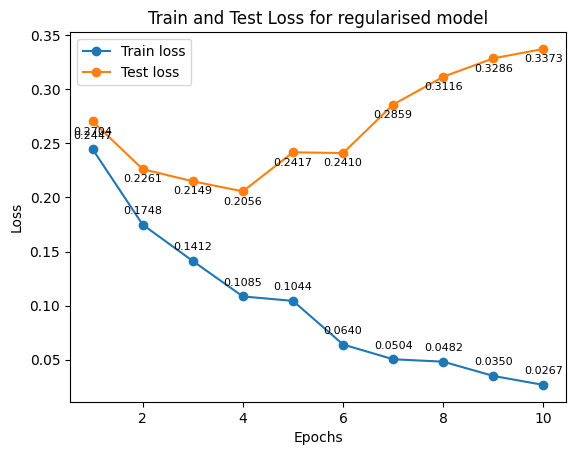

In [10]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

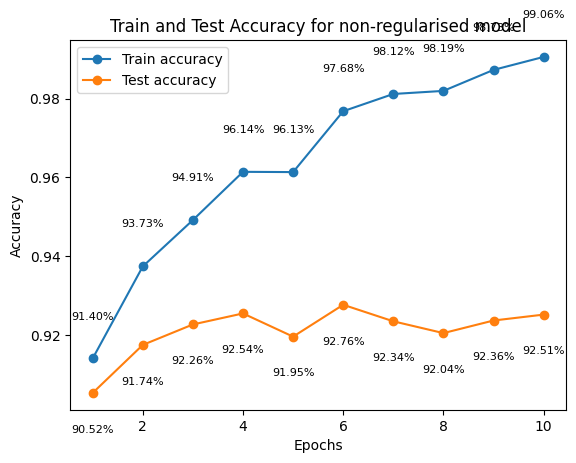

In [11]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [12]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion(useRegularization=False).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = optim.Adam(model.parameters(), lr=1e-3)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.309725  [   64/60000]
loss: 0.489477  [ 6464/60000]
loss: 0.667203  [12864/60000]
loss: 0.417781  [19264/60000]
loss: 0.505982  [25664/60000]
loss: 0.451004  [32064/60000]
loss: 0.381470  [38464/60000]
loss: 0.433022  [44864/60000]
loss: 0.308120  [51264/60000]
loss: 0.209783  [57664/60000]


Epochs:  10%|█         | 1/10 [00:45<06:50, 45.64s/it]

Train Error: 
 Accuracy: 87.6%, Avg loss: 0.331639 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.329234 

Epoch 2:

loss: 0.278632  [   64/60000]
loss: 0.339020  [ 6464/60000]
loss: 0.337785  [12864/60000]
loss: 0.158727  [19264/60000]
loss: 0.381141  [25664/60000]
loss: 0.575199  [32064/60000]
loss: 0.235204  [38464/60000]
loss: 0.483658  [44864/60000]
loss: 0.486509  [51264/60000]
loss: 0.306146  [57664/60000]


Epochs:  20%|██        | 2/10 [01:31<06:07, 45.88s/it]

Train Error: 
 Accuracy: 90.7%, Avg loss: 0.254920 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.273528 

Epoch 3:

loss: 0.310952  [   64/60000]
loss: 0.247421  [ 6464/60000]
loss: 0.373901  [12864/60000]
loss: 0.231859  [19264/60000]
loss: 0.358193  [25664/60000]
loss: 0.218829  [32064/60000]
loss: 0.220379  [38464/60000]
loss: 0.244207  [44864/60000]
loss: 0.165115  [51264/60000]
loss: 0.287724  [57664/60000]


Epochs:  30%|███       | 3/10 [02:17<05:22, 46.01s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.236373 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.253756 

Epoch 4:

loss: 0.154345  [   64/60000]
loss: 0.158360  [ 6464/60000]
loss: 0.166496  [12864/60000]
loss: 0.128372  [19264/60000]
loss: 0.263150  [25664/60000]
loss: 0.193593  [32064/60000]
loss: 0.116377  [38464/60000]
loss: 0.266816  [44864/60000]
loss: 0.129970  [51264/60000]
loss: 0.424313  [57664/60000]


Epochs:  40%|████      | 4/10 [03:04<04:37, 46.25s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.220131 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.243400 

Epoch 5:

loss: 0.146242  [   64/60000]
loss: 0.200981  [ 6464/60000]
loss: 0.221942  [12864/60000]
loss: 0.199853  [19264/60000]
loss: 0.277862  [25664/60000]
loss: 0.244088  [32064/60000]
loss: 0.095024  [38464/60000]
loss: 0.314921  [44864/60000]
loss: 0.231371  [51264/60000]
loss: 0.233172  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:51<03:52, 46.51s/it]

Train Error: 
 Accuracy: 92.1%, Avg loss: 0.209720 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.240067 

Epoch 6:

loss: 0.142181  [   64/60000]
loss: 0.196189  [ 6464/60000]
loss: 0.227363  [12864/60000]
loss: 0.247999  [19264/60000]
loss: 0.308612  [25664/60000]
loss: 0.320582  [32064/60000]
loss: 0.143914  [38464/60000]
loss: 0.096841  [44864/60000]
loss: 0.326330  [51264/60000]
loss: 0.188240  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:38<03:07, 46.76s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.199813 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.229237 

Epoch 7:

loss: 0.175386  [   64/60000]
loss: 0.162582  [ 6464/60000]
loss: 0.296287  [12864/60000]
loss: 0.223391  [19264/60000]
loss: 0.122449  [25664/60000]
loss: 0.160094  [32064/60000]
loss: 0.241936  [38464/60000]
loss: 0.234521  [44864/60000]
loss: 0.126813  [51264/60000]
loss: 0.138368  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:25<02:20, 46.82s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.185989 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.224946 

Epoch 8:

loss: 0.286782  [   64/60000]
loss: 0.237895  [ 6464/60000]
loss: 0.214453  [12864/60000]
loss: 0.116556  [19264/60000]
loss: 0.144693  [25664/60000]
loss: 0.127628  [32064/60000]
loss: 0.222154  [38464/60000]
loss: 0.168495  [44864/60000]
loss: 0.197227  [51264/60000]
loss: 0.139459  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:11<01:32, 46.37s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.172721 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.222640 

Epoch 9:

loss: 0.203525  [   64/60000]
loss: 0.340648  [ 6464/60000]
loss: 0.153827  [12864/60000]
loss: 0.193276  [19264/60000]
loss: 0.114847  [25664/60000]
loss: 0.156661  [32064/60000]
loss: 0.224563  [38464/60000]
loss: 0.095260  [44864/60000]
loss: 0.202710  [51264/60000]
loss: 0.256417  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:56<00:46, 46.11s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.163049 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.208640 

Epoch 10:

loss: 0.264180  [   64/60000]
loss: 0.077381  [ 6464/60000]
loss: 0.211793  [12864/60000]
loss: 0.119352  [19264/60000]
loss: 0.061400  [25664/60000]
loss: 0.134020  [32064/60000]
loss: 0.117972  [38464/60000]
loss: 0.140592  [44864/60000]
loss: 0.177294  [51264/60000]
loss: 0.160276  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:41<00:00, 46.18s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.159364 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.216169 

Done training!


Plotting metrics

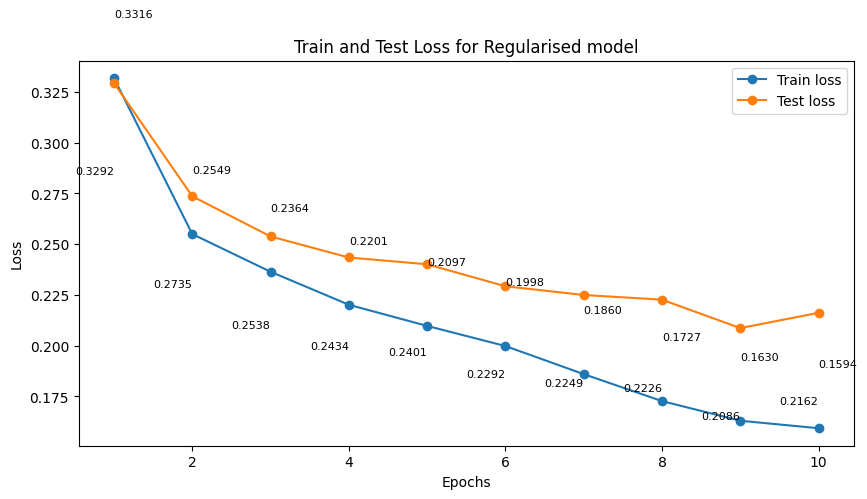

In [13]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

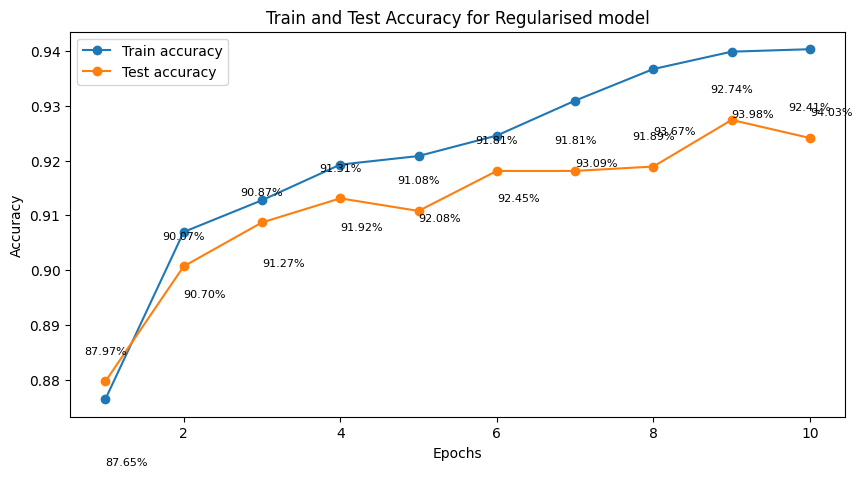

In [14]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [15]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)  # No data augmentation

model = NetFashion(useRegularization=True).to(device)  # useRegularization is True in model init
epochs = 10
optimiser = optim.Adam(model.parameters(), lr=1e-3)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.304687  [   64/60000]
loss: 0.733096  [ 6464/60000]
loss: 0.409253  [12864/60000]
loss: 0.361137  [19264/60000]
loss: 0.391877  [25664/60000]
loss: 0.185166  [32064/60000]
loss: 0.552234  [38464/60000]
loss: 0.203948  [44864/60000]
loss: 0.319396  [51264/60000]
loss: 0.334063  [57664/60000]


Epochs:  10%|█         | 1/10 [00:30<04:31, 30.21s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.235569 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.266742 

Epoch 2:

loss: 0.199855  [   64/60000]
loss: 0.266145  [ 6464/60000]
loss: 0.276331  [12864/60000]
loss: 0.243506  [19264/60000]
loss: 0.294026  [25664/60000]
loss: 0.183355  [32064/60000]
loss: 0.279883  [38464/60000]
loss: 0.093257  [44864/60000]
loss: 0.174574  [51264/60000]
loss: 0.199322  [57664/60000]


Epochs:  20%|██        | 2/10 [01:00<04:04, 30.55s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.191766 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.235149 

Epoch 3:

loss: 0.096657  [   64/60000]
loss: 0.300979  [ 6464/60000]
loss: 0.063836  [12864/60000]
loss: 0.194135  [19264/60000]
loss: 0.236901  [25664/60000]
loss: 0.228951  [32064/60000]
loss: 0.128094  [38464/60000]
loss: 0.063799  [44864/60000]
loss: 0.114742  [51264/60000]
loss: 0.193644  [57664/60000]


Epochs:  30%|███       | 3/10 [01:31<03:32, 30.41s/it]

Train Error: 
 Accuracy: 94.1%, Avg loss: 0.163492 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.226816 

Epoch 4:

loss: 0.180285  [   64/60000]
loss: 0.176955  [ 6464/60000]
loss: 0.251091  [12864/60000]
loss: 0.110991  [19264/60000]
loss: 0.131548  [25664/60000]
loss: 0.150861  [32064/60000]
loss: 0.130058  [38464/60000]
loss: 0.178702  [44864/60000]
loss: 0.214726  [51264/60000]
loss: 0.066945  [57664/60000]


Epochs:  40%|████      | 4/10 [02:01<03:03, 30.51s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.116209 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.201245 

Epoch 5:

loss: 0.227987  [   64/60000]
loss: 0.101114  [ 6464/60000]
loss: 0.099156  [12864/60000]
loss: 0.180291  [19264/60000]
loss: 0.239753  [25664/60000]
loss: 0.153019  [32064/60000]
loss: 0.083162  [38464/60000]
loss: 0.180841  [44864/60000]
loss: 0.212489  [51264/60000]
loss: 0.190375  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:31<02:31, 30.32s/it]

Train Error: 
 Accuracy: 96.6%, Avg loss: 0.091716 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.222955 

Epoch 6:

loss: 0.138850  [   64/60000]
loss: 0.103752  [ 6464/60000]
loss: 0.135635  [12864/60000]
loss: 0.061840  [19264/60000]
loss: 0.284917  [25664/60000]
loss: 0.045801  [32064/60000]
loss: 0.043084  [38464/60000]
loss: 0.249030  [44864/60000]
loss: 0.136849  [51264/60000]
loss: 0.176117  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:02<02:01, 30.44s/it]

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.081336 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.224291 

Epoch 7:

loss: 0.067634  [   64/60000]
loss: 0.161404  [ 6464/60000]
loss: 0.149613  [12864/60000]
loss: 0.060066  [19264/60000]
loss: 0.136686  [25664/60000]
loss: 0.180862  [32064/60000]
loss: 0.190701  [38464/60000]
loss: 0.219152  [44864/60000]
loss: 0.039911  [51264/60000]
loss: 0.136915  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:32<01:31, 30.37s/it]

Train Error: 
 Accuracy: 97.8%, Avg loss: 0.064496 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.227308 

Epoch 8:

loss: 0.100237  [   64/60000]
loss: 0.040486  [ 6464/60000]
loss: 0.058978  [12864/60000]
loss: 0.058558  [19264/60000]
loss: 0.159960  [25664/60000]
loss: 0.065569  [32064/60000]
loss: 0.015381  [38464/60000]
loss: 0.066983  [44864/60000]
loss: 0.109529  [51264/60000]
loss: 0.066613  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:03<01:00, 30.45s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.051606 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.233319 

Epoch 9:

loss: 0.109903  [   64/60000]
loss: 0.014902  [ 6464/60000]
loss: 0.111823  [12864/60000]
loss: 0.118802  [19264/60000]
loss: 0.124741  [25664/60000]
loss: 0.051868  [32064/60000]
loss: 0.081163  [38464/60000]
loss: 0.055097  [44864/60000]
loss: 0.121317  [51264/60000]
loss: 0.030127  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:34<00:30, 30.49s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.040789 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.256436 

Epoch 10:

loss: 0.023561  [   64/60000]
loss: 0.029282  [ 6464/60000]
loss: 0.062321  [12864/60000]
loss: 0.182733  [19264/60000]
loss: 0.098331  [25664/60000]
loss: 0.104492  [32064/60000]
loss: 0.123677  [38464/60000]
loss: 0.066438  [44864/60000]
loss: 0.088688  [51264/60000]
loss: 0.067736  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:04<00:00, 30.45s/it]

Train Error: 
 Accuracy: 98.8%, Avg loss: 0.033958 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.301920 

Done training!


Plotting metrics

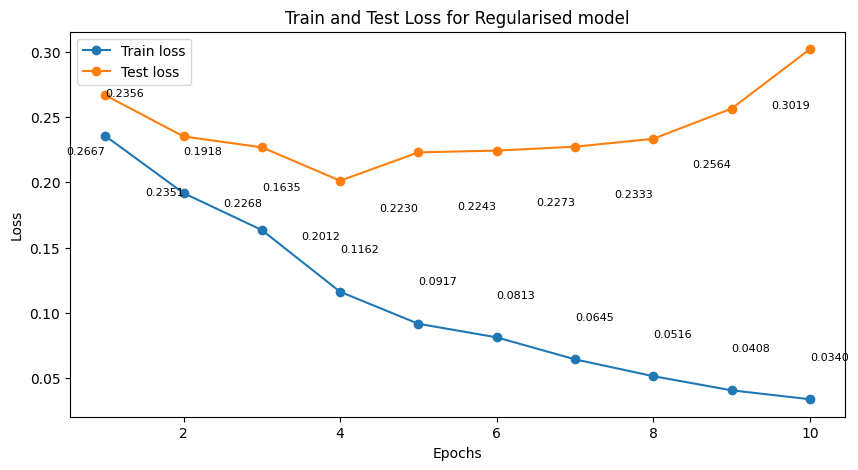

In [16]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

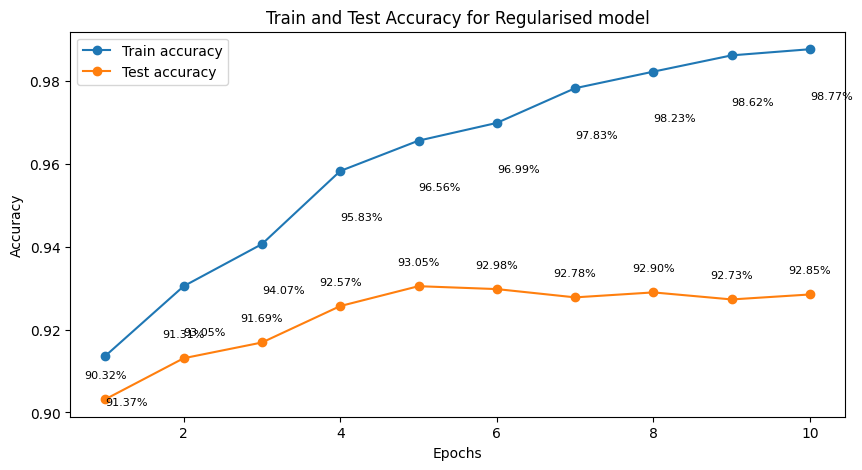

In [17]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [18]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)  # No data augmentation

model = NetFashion(useRegularization=False).to(device)  # useRegularization is False
epochs = 10
optimiser = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Add weight_decay
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302576  [   64/60000]
loss: 0.491266  [ 6464/60000]
loss: 0.696344  [12864/60000]
loss: 0.431578  [19264/60000]
loss: 0.450195  [25664/60000]
loss: 0.594425  [32064/60000]
loss: 0.241419  [38464/60000]
loss: 0.318714  [44864/60000]
loss: 0.338209  [51264/60000]
loss: 0.315112  [57664/60000]


Epochs:  10%|█         | 1/10 [00:31<04:39, 31.05s/it]

Train Error: 
 Accuracy: 89.3%, Avg loss: 0.287652 

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.329659 

Epoch 2:

loss: 0.371812  [   64/60000]
loss: 0.088528  [ 6464/60000]
loss: 0.200620  [12864/60000]
loss: 0.196831  [19264/60000]
loss: 0.263806  [25664/60000]
loss: 0.122101  [32064/60000]
loss: 0.257766  [38464/60000]
loss: 0.390303  [44864/60000]
loss: 0.301370  [51264/60000]
loss: 0.266156  [57664/60000]


Epochs:  20%|██        | 2/10 [01:03<04:17, 32.13s/it]

Train Error: 
 Accuracy: 92.8%, Avg loss: 0.194100 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.251450 

Epoch 3:

loss: 0.093292  [   64/60000]
loss: 0.427314  [ 6464/60000]
loss: 0.330652  [12864/60000]
loss: 0.166007  [19264/60000]
loss: 0.187627  [25664/60000]
loss: 0.256792  [32064/60000]
loss: 0.316948  [38464/60000]
loss: 0.146826  [44864/60000]
loss: 0.349648  [51264/60000]
loss: 0.130300  [57664/60000]


Epochs:  30%|███       | 3/10 [01:36<03:47, 32.48s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.160888 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.235764 

Epoch 4:

loss: 0.249136  [   64/60000]
loss: 0.137320  [ 6464/60000]
loss: 0.054529  [12864/60000]
loss: 0.192599  [19264/60000]
loss: 0.236028  [25664/60000]
loss: 0.227382  [32064/60000]
loss: 0.104222  [38464/60000]
loss: 0.356237  [44864/60000]
loss: 0.183769  [51264/60000]
loss: 0.369056  [57664/60000]


Epochs:  40%|████      | 4/10 [02:09<03:14, 32.46s/it]

Train Error: 
 Accuracy: 95.5%, Avg loss: 0.124291 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.215245 

Epoch 5:

loss: 0.091169  [   64/60000]
loss: 0.155038  [ 6464/60000]
loss: 0.153713  [12864/60000]
loss: 0.254758  [19264/60000]
loss: 0.192637  [25664/60000]
loss: 0.084145  [32064/60000]
loss: 0.183394  [38464/60000]
loss: 0.167395  [44864/60000]
loss: 0.107535  [51264/60000]
loss: 0.139783  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:42<02:43, 32.65s/it]

Train Error: 
 Accuracy: 96.2%, Avg loss: 0.104953 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.221376 

Epoch 6:

loss: 0.137746  [   64/60000]
loss: 0.135900  [ 6464/60000]
loss: 0.136256  [12864/60000]
loss: 0.091979  [19264/60000]
loss: 0.182051  [25664/60000]
loss: 0.189006  [32064/60000]
loss: 0.126487  [38464/60000]
loss: 0.093547  [44864/60000]
loss: 0.091929  [51264/60000]
loss: 0.065692  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:15<02:10, 32.74s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.079221 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.233657 

Epoch 7:

loss: 0.046800  [   64/60000]
loss: 0.094306  [ 6464/60000]
loss: 0.044977  [12864/60000]
loss: 0.072827  [19264/60000]
loss: 0.109984  [25664/60000]
loss: 0.044251  [32064/60000]
loss: 0.096157  [38464/60000]
loss: 0.082134  [44864/60000]
loss: 0.037977  [51264/60000]
loss: 0.121326  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:47<01:38, 32.67s/it]

Train Error: 
 Accuracy: 97.6%, Avg loss: 0.070607 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.249913 

Epoch 8:

loss: 0.062808  [   64/60000]
loss: 0.073251  [ 6464/60000]
loss: 0.030469  [12864/60000]
loss: 0.130471  [19264/60000]
loss: 0.037863  [25664/60000]
loss: 0.033784  [32064/60000]
loss: 0.090060  [38464/60000]
loss: 0.038708  [44864/60000]
loss: 0.092446  [51264/60000]
loss: 0.067535  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:20<01:05, 32.70s/it]

Train Error: 
 Accuracy: 97.9%, Avg loss: 0.057484 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.278446 

Epoch 9:

loss: 0.139027  [   64/60000]
loss: 0.010439  [ 6464/60000]
loss: 0.003154  [12864/60000]
loss: 0.027041  [19264/60000]
loss: 0.076320  [25664/60000]
loss: 0.014154  [32064/60000]
loss: 0.062795  [38464/60000]
loss: 0.080845  [44864/60000]
loss: 0.026942  [51264/60000]
loss: 0.017831  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:53<00:32, 32.70s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.042867 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.281199 

Epoch 10:

loss: 0.016247  [   64/60000]
loss: 0.048483  [ 6464/60000]
loss: 0.020270  [12864/60000]
loss: 0.003969  [19264/60000]
loss: 0.158649  [25664/60000]
loss: 0.037300  [32064/60000]
loss: 0.020832  [38464/60000]
loss: 0.017645  [44864/60000]
loss: 0.057421  [51264/60000]
loss: 0.002263  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:25<00:00, 32.51s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.034547 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.292532 

Done training!


Plotting metrics

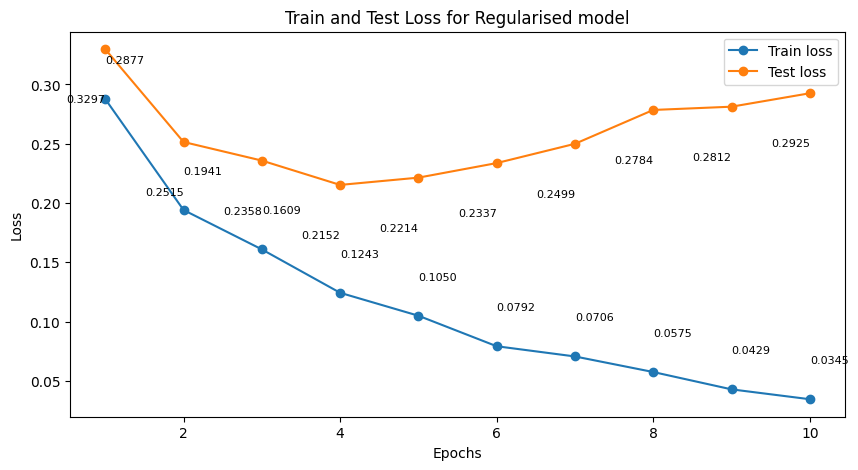

In [19]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

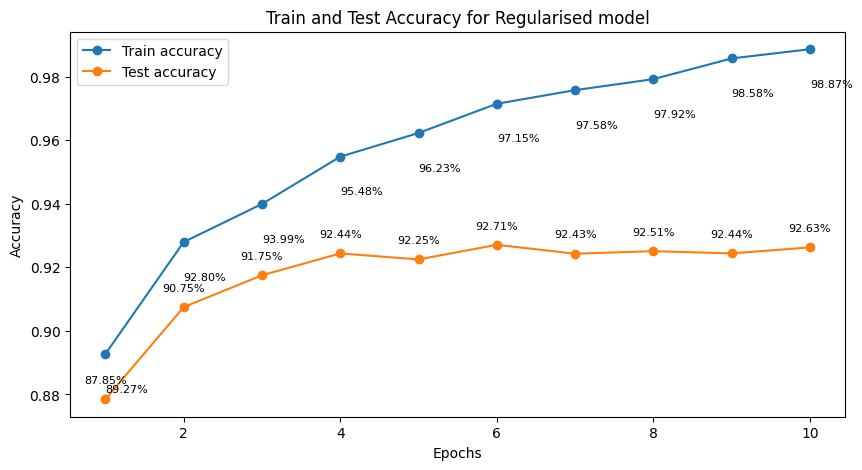

In [20]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [ ]:
# Apply all regularization techniques
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)  # Enable data augmentation

model = NetFashion(useRegularization=True).to(device)  # Enable dropout in the model
epochs = 10
optimiser = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Add weight_decay
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.303649  [   64/60000]
loss: 0.381603  [ 6464/60000]
loss: 0.492082  [12864/60000]
loss: 0.634231  [19264/60000]
loss: 0.348008  [25664/60000]
loss: 0.462559  [32064/60000]
loss: 0.502297  [38464/60000]
loss: 0.326800  [44864/60000]
loss: 0.580953  [51264/60000]
loss: 0.500045  [57664/60000]


Epochs:  10%|█         | 1/10 [00:50<07:32, 50.33s/it]

Train Error: 
 Accuracy: 86.9%, Avg loss: 0.351470 

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.351944 

Epoch 2:

loss: 0.286028  [   64/60000]
loss: 0.272201  [ 6464/60000]
loss: 0.235188  [12864/60000]
loss: 0.278437  [19264/60000]
loss: 0.318452  [25664/60000]
loss: 0.251364  [32064/60000]
loss: 0.510044  [38464/60000]
loss: 0.205632  [44864/60000]
loss: 0.234498  [51264/60000]
loss: 0.251257  [57664/60000]


Plotting metrics

In [ ]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>Overfitting happens when a model memorizes the training data instead of learning general patterns. To fix this, we can use data augmentation to create variations of existing data, dropout to randomly ignore parts of the model during training, and weight decay to stop large weights and encourage simpler solutions. These techniques help the model generalize better to new data, closing the gap between training and test performance. I noticed in the FashionMNIST example that using these techniques, alone or in combination, led to improved test accuracy and less overfitting.</font>

